# Generating the Synthetic Dataset
Suppose our dataset has the following columns:

* customer_age: Customer age (18 to 80 years).
* account_balance: Account balance (0 to 50,000).
* tenure: Years as a customer (0 to 20).
* num_products: Number of products purchased (1 to 5).
* gender: Gender (category: "Male" or "Female").
* starting_salary: Starting salary (continuous variable), which is generated from a linear function of the other variables plus some noise.

The target is defined as follows:

starting_salary = 20000 + 500 × customer_age + 0.3 × account_balance + 1000 × tenure + 1500 × num_products + gender_effect + noise

where:

* gender_effect = 2000 if gender is "Male"
* gender_effect = 0 if gender is "Female"
* If gender is NaN, we will assign an intermediate value (e.g. 1000).
* noise is random noise (normal distribution, mean 0, standard deviation 5000).

Additionally, missing values ​​(NaN) will be introduced in some columns:

10% NaN in customer_age
5% NaN in account_balance
2% NaN in gender

In [1]:
import numpy as np
import pandas as pd

# 1. Creating the dataset

In [2]:
# Fixing seed
np.random.seed(42)

In [3]:
# Number of observations
n = 18000

In [4]:
# Generate data for each variable:
customer_age = np.random.randint(18, 81, size = n).astype(float)
account_balance = np.random.randint(0, 50001, size = n).astype(float)
tenure = np.random.randint(0, 21, size = n)
num_products = np.random.randint(1, 6, size = n)

In [5]:
# Transform 'gender' column to object type to allow NaN
gender = np.random.choice(['Male', 'Female'], size = n, p = [0.5, 0.5]).astype(object)

In [6]:
# Introduce controled NaN values:
mask_age = np.random.rand(n) < 0.10         # 10% NaN on customer_age
customer_age[mask_age] = np.nan

mask_balance = np.random.rand(n) < 0.05     # 5% NaN on account_balance
account_balance[mask_balance] = np.nan

mask_gender = np.random.rand(n) < 0.02      # 2% NaN on gender
gender[mask_gender] = np.nan

In [7]:
# Define sigmoid function (will not be used directly in regression, but serves to illustrate)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
# Gender effect:
gender_effect = np.array([2000 if g == 'Male' else 0 if g == 'Female' else 1000 for g in gender])

In [9]:
# Generate noise:
noise = np.random.normal(0, 5000, size = n)

In [10]:
# Calculating 'starting_salary' according to the formula:
starting_salary = (20000 +
                   500 * customer_age +
                   0.3 * account_balance +
                   1000 * tenure +
                   1500 * num_products +
                   gender_effect +
                   noise)

starting_salary = starting_salary.astype(float)

# 2. Creating the DataFrame

In [11]:
data = {
    'customer_age': customer_age,
    'account_balance': account_balance,
    'tenure': tenure,
    'num_products': num_products,
    'gender': gender,
    'starting_salary': starting_salary
}

In [12]:
df = pd.DataFrame(data)

In [13]:
df.head()

,customer_age,account_balance,tenure,num_products,gender,starting_salary
0,56.0,35185.0,0,4,Male,67958.787225
1,69.0,49684.0,19,4,Male,100457.461152
2,46.0,13463.0,20,4,Female,75891.781072
3,32.0,25474.0,3,2,Female,53259.194412
4,60.0,40935.0,8,5,Female,75081.014697


# 3. Solving problems related to NaN values

In [14]:
for i in range(len(df['starting_salary'])):
    if np.isnan(df.loc[i, 'starting_salary']):
        df = df.drop(i)

In [15]:
# Some importante verifications:
print("First rows of the dataset:")
print(df.head())
print("\nNan values for each column:")
print(df.isnull().sum())

First rows of the dataset:
   customer_age  account_balance  tenure  num_products  gender  \
0          56.0          35185.0       0             4    Male   
1          69.0          49684.0      19             4    Male   
2          46.0          13463.0      20             4  Female   
3          32.0          25474.0       3             2  Female   
4          60.0          40935.0       8             5  Female   

   starting_salary  
0     67958.787225  
1    100457.461152  
2     75891.781072  
3     53259.194412  
4     75081.014697  

Nan values for each column:
customer_age         0
account_balance      0
tenure               0
num_products         0
gender             307
starting_salary      0
dtype: int64


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 4. Defining numeric and categorical columns

In [17]:
numeric_features = ['customer_age', 'account_balance', 'tenure', 'num_products']
categorical_features = ['gender']

# 5. Pipelines

In [18]:
# Pipeline for numeric variables: imputing with the mean and scaling
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

In [19]:
# Pipeline for categorical variables: imputing with the mode and One-Hot Encoding
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [20]:
# Combining both pipelines in one ColumnTransformer
preprocessor = ColumnTransformer(transformers = [
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [21]:
# Building the complete pipeline: preprocessing + regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 5. Separate the features (X) and the target variable (y)

In [22]:
X = df.drop('starting_salary', axis=1)
y = df['starting_salary']

# 6. Training and testing sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid = {
    # Adjusting the imputation strategy in numerical variables: "mean" or "median"
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    # Adjust the regressor parameters (e.g. fit_intercept in LinearRegression)
    'regressor__fit_intercept': [True, False]  # Ejemplo para LinearRegression
}

# 7. Configure GridSearchCV with 5-fold cross-validation and change scoring to a regression metric

In [26]:
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'neg_mean_squared_error') # or 'r^2'

In [27]:
# Training the GridSearch
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['customer_age',
                                                                          'account_balance',
                                                                          'tenure',
                                                                          'num_products']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['gender'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median'],
                         'regressor__fit_intercept': [True, False]},
             scoring='neg_mean_squared_error')

# 8. Print the best parameters and the best score in cross validation

In [28]:
print("Best parameters:", grid_search.best_params_)
print("Best accuracy in cross validation:", grid_search.best_score_)

Best parameters: {'preprocessor__num__imputer__strategy': 'mean', 'regressor__fit_intercept': False}
Best accuracy in cross validation: -24821782.724746995


# 9. Evaluate the fitted model on the test set

In [29]:
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Accuracy in testing with the best model: {test_accuracy * 100:.2f}%")

Accuracy in testing with the best model: 85.68%


In [30]:
y_pred = best_model.predict(X_test)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# 9. Scatter Plot: Predictions vs. Real Values

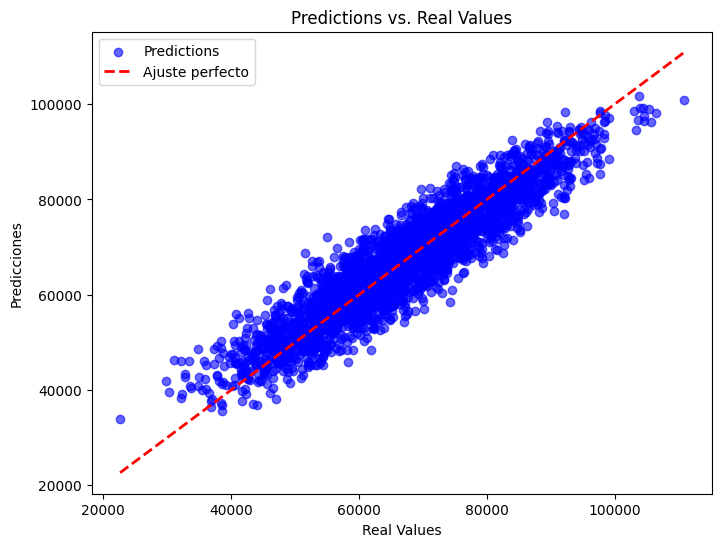

In [32]:

plt.figure(figsize = (8, 6))
plt.scatter(y_test, y_pred, alpha = 0.6, color = 'blue', label = 'Predictions')

# Draw the 45° line that represents the perfect prediction: y = x
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth = 2, label = 'Ajuste perfecto')
plt.xlabel('Real Values')
plt.ylabel('Predicciones')
plt.title('Predictions vs. Real Values')
plt.legend()
plt.show()

# 10. Histogram of the residuals (errors)

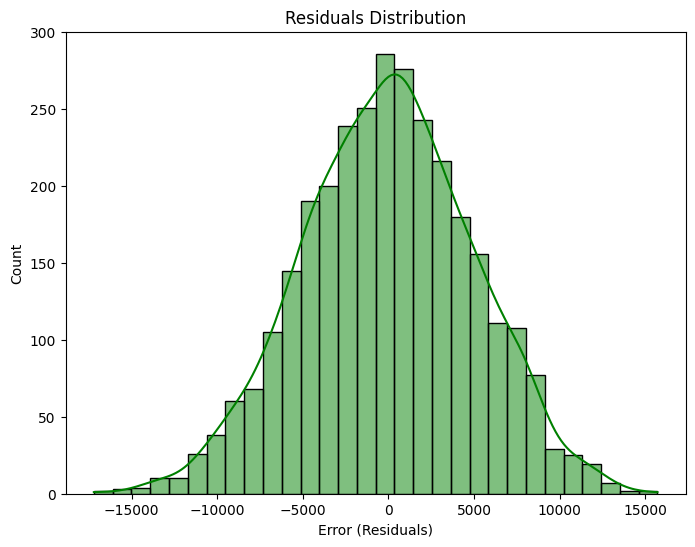

In [36]:
residuals = y_test - y_pred
plt.figure(figsize = (8, 6))
sns.histplot(residuals, kde=True, color = 'green', bins = 30)
plt.xlabel('Error (Residuals)')
plt.title('Residuals Distribution')
plt.show()

# 11. Residuals vs. Predictions Plot

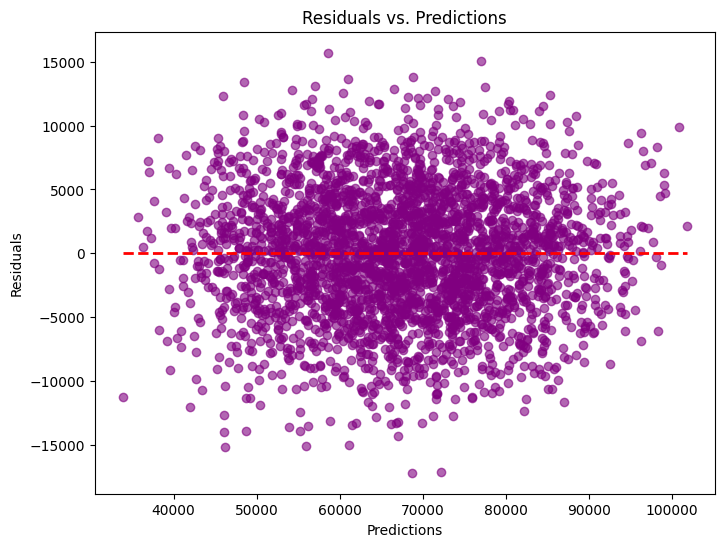

In [34]:
plt.figure(figsize = (8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='purple')
plt.hlines(0, y_pred.min(), y_pred.max(), colors = 'red', linestyles = '--', linewidth = 2)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predictions')
plt.show()

# 12. Evaluate the model using MSE and R²

In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

MSE: 4978.31
R^2: 0.86
